# **Football Match Data Preparation Pipeline**

## **Overview**
This notebook implements a comprehensive data preparation pipeline for football match prediction, with focus on:
- **Data Quality**: Cleaning, validation, and anomaly detection
- **Feature Engineering**: Time-based features, rolling statistics, H2H metrics
- **Leak Prevention**: Strict chronological ordering and proper shifting
- **Reproducibility**: Modular functions and clear configuration

**Target**: Predict "Cinderella" upsets - when underdogs win against heavy favorites

---
# **Part 0: Setup**

## **0.1 Library Imports**

In [63]:
# Data manipulation
import pandas as pd
import numpy as np
import os
from datetime import timedelta 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)
from sklearn.utils import resample
from datetime import timedelta

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import shap

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## **0.2 Constants and Configuration**

In [64]:
# FILE PATHS
RAW_DATA_PATH = "data/Matches.csv"
PROCESSED_DATA_PATH = "data/Matches_Prepared.csv"

# DATA FILTERING
TOP_LEAGUES = ['E0', 'SP1', 'D1', 'I1', 'F1']  # Premier League, La Liga, Bundesliga, Serie A, Ligue 1

# FEATURE ENGINEERING PARAMETERS
HOME_ADVANTAGE = 100  # Elo points added to home team
PROB_THRESHOLD = 0.3  # Maximum underdog win probability to classify as "cinderella"
ROLLING_WINDOWS = [3, 5]  # Window sizes for rolling statistics

# FEATURE  OPTIONS
USE_HOME_AWAY = True
USE_UNDERDOG_FAV = False
USE_DIFFERENCE = False

# Seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# UPDATE PROCESSED FILE
UPDATE_PROCESSED_FILE = True

# RUN CODE
RUN_CODE = True

## **0.3 Data Loading**

In [65]:
def load_data(path):
    """
    Load raw match data.
    """
    print(f"📂 Loading data from: {path}")
    df = pd.read_csv(path)
    print(f"   Initial shape: {df.shape}")

    return df

In [66]:
if RUN_CODE:
    # Load data
    df_original = load_data(RAW_DATA_PATH)

    print("\n📋 Dataset Preview:")
    print(df_original.head())

📂 Loading data from: data/Matches.csv
   Initial shape: (230557, 48)

📋 Dataset Preview:
  Division  MatchDate MatchTime   HomeTeam    AwayTeam   HomeElo   AwayElo  Form3Home  Form5Home  Form3Away  Form5Away  FTHome  FTAway FTResult  HTHome  HTAway HTResult  HomeShots  AwayShots  HomeTarget  AwayTarget  HomeFouls  AwayFouls  HomeCorners  AwayCorners  HomeYellow  AwayYellow  HomeRed  AwayRed  OddHome  OddDraw  OddAway  MaxHome  MaxDraw  MaxAway  Over25  Under25  MaxOver25  MaxUnder25  HandiSize  HandiHome  HandiAway  C_LTH  C_LTA  C_VHD  C_VAD  C_HTB  C_PHB
0       F1  7/28/2000       NaN  Marseille      Troyes 1686.3400 1586.5700     0.0000     0.0000     0.0000     0.0000  3.0000  1.0000        H  2.0000  1.0000        H        NaN        NaN         NaN         NaN        NaN        NaN          NaN          NaN         NaN         NaN      NaN      NaN   1.6500   3.3000   4.3000      NaN      NaN      NaN     NaN      NaN        NaN         NaN        NaN        NaN        NaN    Na

In [67]:
if RUN_CODE:
    print("📊 Data info:")
    df_original.info()

📊 Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230557 entries, 0 to 230556
Data columns (total 48 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Division     230557 non-null  object 
 1   MatchDate    230557 non-null  object 
 2   MatchTime    99072 non-null   object 
 3   HomeTeam     230557 non-null  object 
 4   AwayTeam     230557 non-null  object 
 5   HomeElo      141597 non-null  float64
 6   AwayElo      141528 non-null  float64
 7   Form3Home    229057 non-null  float64
 8   Form5Home    229057 non-null  float64
 9   Form3Away    229057 non-null  float64
 10  Form5Away    229057 non-null  float64
 11  FTHome       230554 non-null  float64
 12  FTAway       230554 non-null  float64
 13  FTResult     230554 non-null  object 
 14  HTHome       175977 non-null  float64
 15  HTAway       175977 non-null  float64
 16  HTResult     175977 non-null  object 
 17  HomeShots    114735 non-null  float64
 18  AwayShots  

---
# **Part 1: Initial Cleaning and Preprocessing**

## **1.1 Filtering available data**

Since the target is to predict ... -> we can only use historical or pre-match data: (focus on 5 big league)

- `Division`
- `MatchDate`
- `MatchTime`
- `HomeTeam`
- `AwayTeam`
- `HomeElo`
- `AwayElo`
- `Form3Home`
- `Form5Home`
- `Form3Away`
- `Form5Away`

and some other columns for further feature engineering:

- `FTHome`
- `FTAway`
- `FTResult`
- `HomeShots`
- `AwayShots`
- `HomeTarget`
- `AwayTarget`
- `HomeCorners`
- `AwayCorners`
- `HomeFouls`
- `AwayFouls`
- `HomeYellow`
- `AwayYellow`
- `HomeRed`
- `AwayRed`

In [68]:
def filter_data(df):
    """
    Filter and select relevant columns for analysis.
    """
    print(f"Step 1.1 Filtering data:")
    
    # Filter for top leagues only
    df = df[df['Division'].isin(TOP_LEAGUES)].copy()

    # Define relevant columns
    relevant_columns = [
        'Division', 'MatchDate', 'MatchTime', 'HomeTeam', 'AwayTeam', 'HomeElo', 'AwayElo', 
        'Form3Home', 'Form3Away', 'Form5Home', 'Form5Away',
        'FTHome', 'FTAway', 'FTResult',
        'HomeShots', 'AwayShots', 'HomeTarget', 'AwayTarget',
        'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
        'HomeYellow', 'AwayYellow', 'HomeRed', 'AwayRed'
    ]
    
    # Filter columns
    df_filtered = df[relevant_columns].copy()
    print(f"   After filtering relevant columns: {df_filtered.shape}")

    return df_filtered

In [69]:
if RUN_CODE:
    df_prepared = filter_data(df_original)
    print("Filter completed. Preview of prepared data:")
    print(df_prepared.head())

Step 1.1 Filtering data:
   After filtering relevant columns: (43708, 26)
Filter completed. Preview of prepared data:
  Division  MatchDate MatchTime   HomeTeam    AwayTeam   HomeElo   AwayElo  Form3Home  Form3Away  Form5Home  Form5Away  FTHome  FTAway FTResult  HomeShots  AwayShots  HomeTarget  AwayTarget  HomeCorners  AwayCorners  HomeFouls  AwayFouls  HomeYellow  AwayYellow  HomeRed  AwayRed
0       F1  7/28/2000       NaN  Marseille      Troyes 1686.3400 1586.5700     0.0000     0.0000     0.0000     0.0000  3.0000  1.0000        H        NaN        NaN         NaN         NaN          NaN          NaN        NaN        NaN         NaN         NaN      NaN      NaN
1       F1  7/28/2000       NaN   Paris SG  Strasbourg 1714.8900 1642.5100     0.0000     0.0000     0.0000     0.0000  3.0000  1.0000        H        NaN        NaN         NaN         NaN          NaN          NaN        NaN        NaN         NaN         NaN      NaN      NaN
3       F1  7/29/2000       NaN    Auxerre

In [70]:
if RUN_CODE:
    # Check missing values
    print("\n📉 Missing Values Percentage per Column:")
    df_prepared.isnull().mean().sort_values(ascending=False)


📉 Missing Values Percentage per Column:


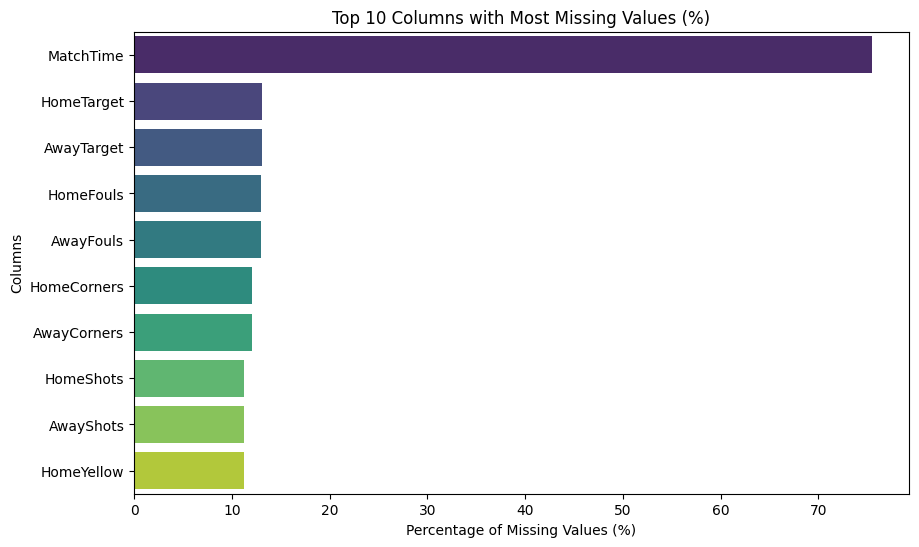

In [71]:
if RUN_CODE:
    # bar chart for top 10 columns with most missing values
    missing_percent = df_prepared.isnull().mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_percent.values * 100, y=missing_percent.index, palette="viridis")
    plt.title("Top 10 Columns with Most Missing Values (%)")
    plt.xlabel("Percentage of Missing Values (%)")
    plt.ylabel("Columns")
    plt.show()

Nhìn vào biểu đồ ma trận (missingno), chúng ta thấy ngay được "cấu trúc" của sự thiếu hụt:

Cột MatchTime (Cột thứ 3 từ trái sang): Gần như trắng xóa. Điều này cho thấy thông tin về giờ thi đấu bị thiếu trầm trọng.

Quyết định: Đây là "tiếng ồn" (noise) chứ không phải tín hiệu. Chúng ta sẽ loại bỏ (drop) cột này ngay lập tức để giảm tải .

Các cột Thống kê trận đấu (HomeShots, AwayShots, Corners, Fouls...): Bạn có thấy các vạch trắng nằm ngang tập trung ở phần trên của biểu đồ không?

Insight: Dữ liệu bóng đá lịch sử thường không được ghi chép đầy đủ các chỉ số chi tiết (shots, corners) ở những năm đầu (năm 2000-2010). Càng về sau (phần dưới biểu đồ), dữ liệu càng đặc (màu đen), tức là đầy đủ hơn.

Vấn đề: Để tính toán GDI (Chỉ số áp đảo) hay Sự mệt mỏi, chúng ta cần những con số này. Nếu giữ lại các trận đấu thiếu chỉ số, mô hình sẽ bị "mù".

## **1.2 Data Cleaning**

In [72]:
def clean_data(df):
    """
    Clean and preprocess the data.
    """
    print("Step 1.2 Cleaning data")

    # Convert MatchDate to datetime
    df['MatchDate'] = pd.to_datetime(df['MatchDate'], dayfirst=True, errors='coerce')
    print("   Converted MatchDate to datetime.")
    
    # Sort by date
    df = df.sort_values(by='MatchDate').reset_index(drop=True)
    print("   Sorted data by MatchDate.")
    
    # Drop MatchTime as missing values are high
    if 'MatchTime' in df.columns:
        df = df.drop(columns=['MatchTime'])
        print("   Dropped MatchTime column.")

    # remove invalid rows
    initial_len = len(df)
    
    condition_valid_score = (df['FTHome'] >= 0) & (df['FTAway'] >= 0)
    condition_valid_elo = (df['HomeElo'] > 0) & (df['AwayElo'] > 0)
    
    df = df[condition_valid_score & condition_valid_elo].copy()
    
    print(f"   Removed {initial_len - len(df)} rows with invalid scores/Elo.")

    # remove Duplicates
    before_dedup = len(df)
    df = df.drop_duplicates()
    if len(df) < before_dedup:
        print(f"   Removed {before_dedup - len(df)} duplicate rows.")

    # remove outliers in Elo ratings
    # elo_cols = ['HomeElo', 'AwayElo']
    # for col in elo_cols:
    #     q1 = df[col].quantile(0.01)
    #     q99 = df[col].quantile(0.99)
    #     before_outlier_removal = len(df)
    #     df = df[(df[col] >= q1) & (df[col] <= q99)]
    #     if len(df) < before_outlier_removal:
    #         print(f"   Removed {before_outlier_removal - len(df)} outlier rows based on {col}.")

    return df

In [73]:
if RUN_CODE:
    df_prepared = clean_data(df_prepared)
    print("Cleaning completed")

Step 1.2 Cleaning data
   Converted MatchDate to datetime.
   Sorted data by MatchDate.
   Dropped MatchTime column.
   Removed 40 rows with invalid scores/Elo.
Cleaning completed


## **1.3 Check Outliers and Invalid Data**

In [74]:
def plot_dist(df):
    """
    Plot distribution for outliers check.
    """
    # pick important numeric columns
    numeric_cols = ['HomeElo', 'AwayElo', 'HomeShots', 'AwayShots', 'FTHome', 'FTAway', 'HomeTarget', 'AwayTarget']
    
    # Set up the plot grid
    fig, axes = plt.subplots(2, 4, figsize=(18, 10))
    fig.suptitle('Distribution of Key Metrics: Identifying Outliers vs. Natural Variance', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for i, col in enumerate(numeric_cols):
        if col in df.columns:
            sns.histplot(df[col], kde=True, ax=axes[i], color='#4c72b0', bins=30)
            
            axes[i].set_title(f'{col} Distribution', fontweight='bold')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            
            q99 = df[col].quantile(0.99)
            axes[i].axvline(q99, color='red', linestyle='--', linewidth=1)
            axes[i].text(q99, axes[i].get_ylim()[1]*0.9, ' 99th %', color='red', fontsize=9)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92) 
    plt.show()

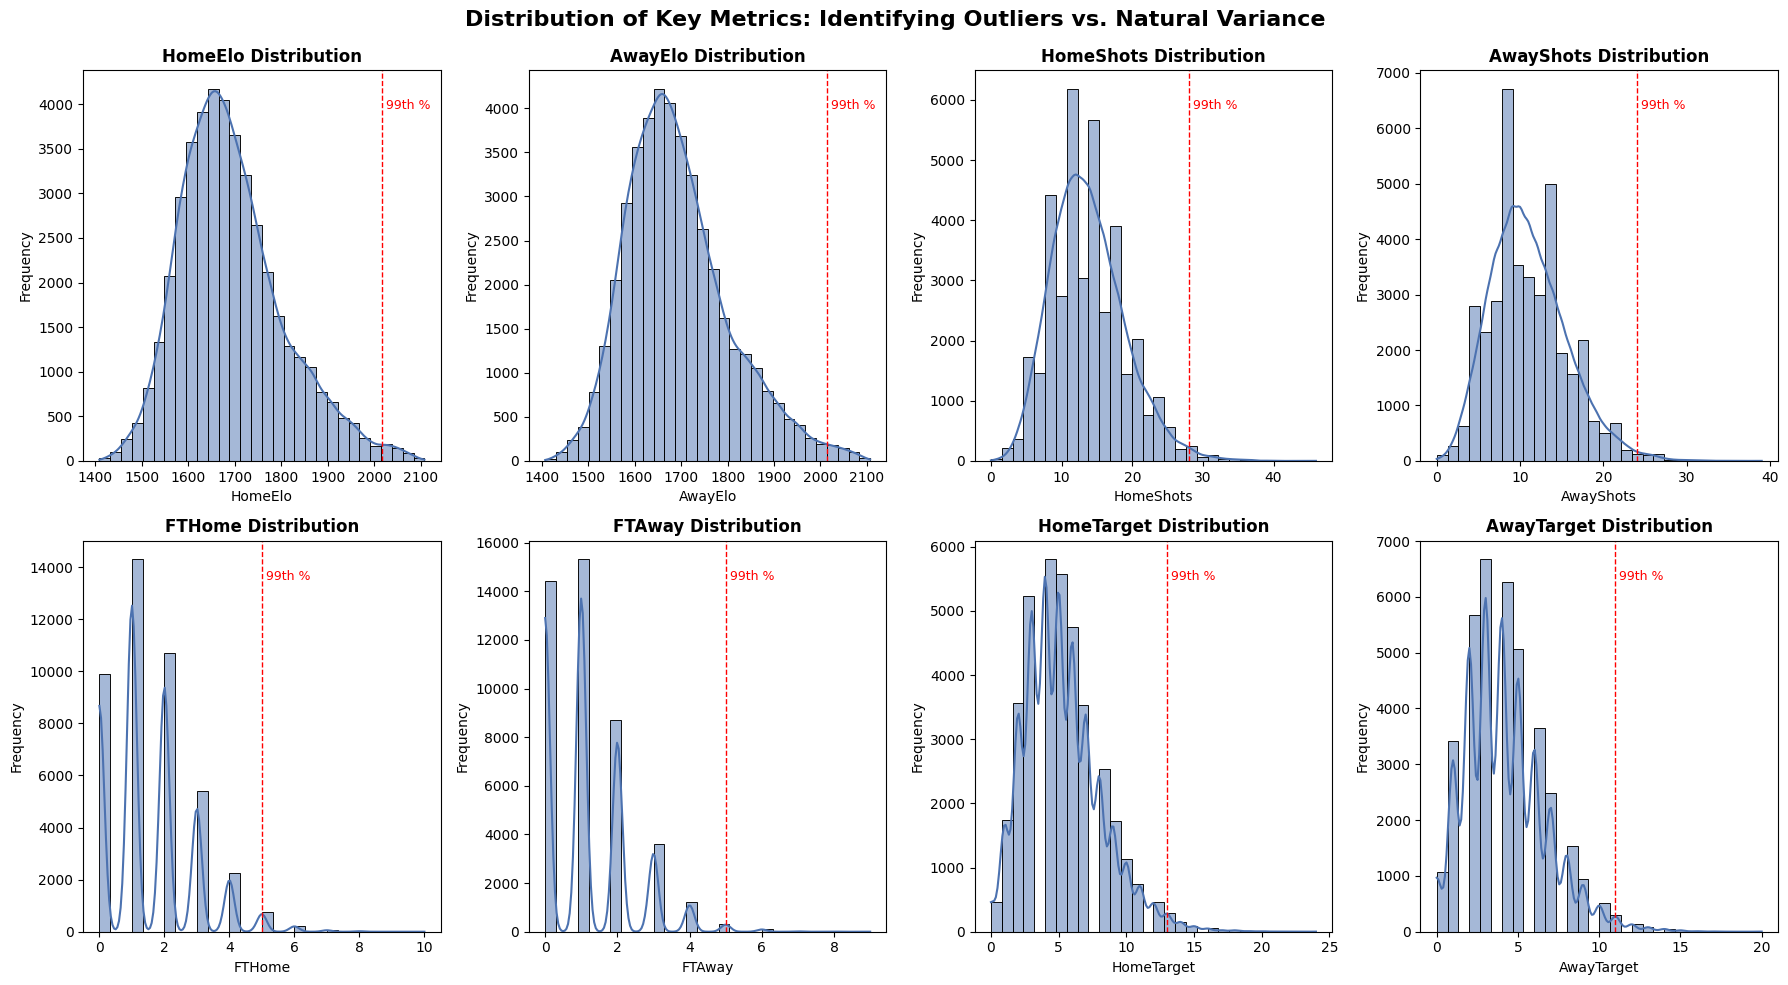

In [75]:
if RUN_CODE:
    plot_dist(df_prepared)

1. Câu chuyện từ biểu đồ
Elo Distribution:

Quan sát: Phân phối hình chuông (Bell curve) rất đẹp và chuẩn. Dải giá trị tập trung từ 1400-1800.

Insight: Các giá trị nằm ngoài vạch đỏ (99th percentile ~ 2000+) không phải là lỗi. Đó là những "Gã khổng lồ" (Real Madrid, Man City, Bayern...).

Kết luận: Nếu chúng ta loại bỏ những điểm này (trim outliers), chúng ta sẽ mất đi "nhân vật phản diện" trong câu chuyện Cinderella. Làm sao có Cinderella nếu không có Gã khổng lồ để đánh bại? -> GIỮ NGUYÊN.

Shots & Targets:

Quan sát: Phân phối lệch phải (Right-skewed) với cái đuôi dài. Có những trận HomeShots lên tới 30-40.

Insight: Những trận đấu có 30 cú sút mà không ghi bàn (hoặc thua ngược) chính là kịch bản kinh điển của "Cinderella". Ví dụ: Celtic thắng Barcelona 2-1 dù chỉ cầm bóng 11%.

Kết luận: Đây là tín hiệu (signal), không phải nhiễu (noise). -> GIỮ NGUYÊN. 

**Đó là AI nói thế nhưng chạy thử thì thấy loại bớt outlier lại cải thiện được model một chút :] nên tạm thời loại bớt đã.**

---
# **Part 2: Target Variable**

## **2.1 Create Target feature**

In [76]:
def create_target_feature(df, home_advantage=HOME_ADVANTAGE, prob_threshold=PROB_THRESHOLD):
    """
     Create target feature 'is_cinderella' based on underdog wins with low probability.
    """
    print(" Step 2.1: Creating Target Feature")
    df['Elo_diff'] = (df['HomeElo'] + home_advantage - df['AwayElo'])
    df['Prob_HomeWin'] = 1 / (1 + 10 ** (-df['Elo_diff'] / 400))
    df['Prob_AwayWin'] = 1 - df['Prob_HomeWin']

    # Determine favorite and underdog based on probability
    df['favorite'] = np.where(df['Prob_HomeWin'] >= 0.5, 'Home', 'Away')
    df['underdog'] = np.where(df['favorite'] == 'Home', 'Away', 'Home')

    # Get the underdog's win probability
    df['Prob_UnderdogWin'] = np.where(df['underdog'] == 'Home', df['Prob_HomeWin'], df['Prob_AwayWin'])

    # Determine if the result is a cinderella win
    underdog_wins = (
        ((df['underdog'] == 'Home') & (df['FTResult'] == 'H')) |
        ((df['underdog'] == 'Away') & (df['FTResult'] == 'A'))
    )
    is_low_prob = (df['Prob_UnderdogWin'] < prob_threshold)
    df['is_cinderella'] = (underdog_wins & is_low_prob).astype(int)

    print("   ✓ Target feature 'is_cinderella' created.")
    
    return df

In [77]:
if RUN_CODE:
    df_prepared = create_target_feature(df_prepared)
    print(f'  Cinderella rate: {df_prepared["is_cinderella"].mean() * 100:.2f}%')

 Step 2.1: Creating Target Feature
   ✓ Target feature 'is_cinderella' created.
  Cinderella rate: 5.81%


---
# **Part 3: Advanced Feature Engineering**

## **Critical Note on Data Leakage Prevention**
All rolling calculations use `.shift(1)` before `.rolling()` to ensure we only use information available **before** each match.

## **3.1 Helper function for feature creation**

In [78]:
def count_matches_in_window(g, days=10):
    g = g.sort_values('MatchDate').copy()
    counts = []
    for idx in g.index:
        current_date = g.at[idx, 'MatchDate']
        window_start = current_date - pd.Timedelta(days=days)
        matches_before = g[(g['MatchDate'] >= window_start) & (g['MatchDate'] < current_date)]
        counts.append(len(matches_before))
    return pd.Series(counts, index=g.index)

## **3.2 Feature Engineering**

In [79]:
# creating new features with no leakage
def feature_engineering(df):
    print("\n Starting feature engineering...")

    df = df.sort_values('MatchDate').reset_index(drop=True)
    df['_match_id'] = np.arange(len(df))

    # ===================================================================
    # === A. Home/Away Features ===
    # ===================================================================

    print(" A. Creating Home/Away Features...")

    # ===================================================================
    # === 1. Rest Days and Congestion ===
    # ===================================================================

    # Number of days since last match for home and away teams
    # and congestion in last 10 days (number of matches played in last 10 days)
    print("   1.1. Calculating Rest Days...")
    team_dates_home = df[['_match_id', 'MatchDate', 'HomeTeam']].copy()
    team_dates_home.columns = ['_match_id', 'MatchDate', 'team']
    team_dates_home['is_home'] = 1

    team_dates_away = df[['_match_id', 'MatchDate', 'AwayTeam']].copy()
    team_dates_away.columns = ['_match_id', 'MatchDate', 'team']
    team_dates_away['is_home'] = 0

    team_dates = pd.concat([team_dates_home, team_dates_away], ignore_index=True)
    team_dates = team_dates.sort_values(['team', 'MatchDate']).reset_index(drop=True)
    team_dates['last_match_date'] = team_dates.groupby('team')['MatchDate'].shift(1)
    team_dates['rest_days'] = (team_dates['MatchDate'] - team_dates['last_match_date']).dt.days

    home_rest = team_dates[team_dates['is_home'] == 1].set_index('_match_id')['rest_days']
    away_rest = team_dates[team_dates['is_home'] == 0].set_index('_match_id')['rest_days']

    df['RestDaysHome'] = df['_match_id'].map(home_rest)
    df['RestDaysAway'] = df['_match_id'].map(away_rest)
    print("      ✓ Rest Days calculated.")

    print("   1.2. Calculating Congestion (matches in last 10 days)...")
    team_dates_home = df[['_match_id', 'MatchDate', 'HomeTeam']].copy()
    team_dates_home.columns = ['_match_id', 'MatchDate', 'team']
    team_dates_home['is_home'] = 1
    
    team_dates_away = df[['_match_id', 'MatchDate', 'AwayTeam']].copy()
    team_dates_away.columns = ['_match_id', 'MatchDate', 'team']
    team_dates_away['is_home'] = 0
    
    team_dates = pd.concat([team_dates_home, team_dates_away], ignore_index=True)
    team_dates = team_dates.sort_values(['team', 'MatchDate']).reset_index(drop=True)
    
    team_dates['congestion_10d'] = team_dates.groupby('team', group_keys=False).apply(
        lambda g: count_matches_in_window(g, 10)
    )
    home_congestion = team_dates[team_dates['is_home'] == 1].set_index('_match_id')['congestion_10d']
    away_congestion = team_dates[team_dates['is_home'] == 0].set_index('_match_id')['congestion_10d']
    
    df['CongestionHome_10d'] = df['_match_id'].map(home_congestion)
    df['CongestionAway_10d'] = df['_match_id'].map(away_congestion)
    print("      ✓ Congestion calculated.")


    # ===================================================================
    # === 2. Elo changes ===
    # ===================================================================

    # Calcuate Elo changes over past 1 month and 2 months for home and away teams
    print("   2. Calculating Elo Changes (1 month & 2 months)...")
    home_elo_data = df[['MatchDate', 'HomeTeam', 'HomeElo', '_match_id']].copy()
    home_elo_data.columns = ['MatchDate', 'team', 'elo', '_match_id']
    home_elo_data['is_home'] = 1

    away_elo_data = df[['MatchDate', 'AwayTeam', 'AwayElo', '_match_id']].copy()
    away_elo_data.columns = ['MatchDate', 'team', 'elo', '_match_id']
    away_elo_data['is_home'] = 0

    team_elo = pd.concat([home_elo_data, away_elo_data], ignore_index=True)
    team_elo = team_elo.sort_values(['team', 'MatchDate']).reset_index(drop=True)

    team_elo['MatchDate_ref_1m'] = team_elo['MatchDate'] - pd.Timedelta(days=30)
    team_elo['MatchDate_ref_2m'] = team_elo['MatchDate'] - pd.Timedelta(days=60)

    right_df_sorted = team_elo[['team', 'MatchDate', 'elo']].rename(columns={'elo': 'past_elo'}).sort_values('MatchDate')

    merged_1m = pd.merge_asof(
        team_elo.sort_values('MatchDate_ref_1m'), # Sắp xếp theo cột bên trái
        right_df_sorted,
        left_on='MatchDate_ref_1m',
        right_on='MatchDate',
        by='team',
        direction='backward' # Tìm giá trị gần nhất TRƯỚC ngày tham chiếu
    )
    merged_1m['EloChange1'] = merged_1m['elo'] - merged_1m['past_elo']

    merged_2m = pd.merge_asof(
        team_elo.sort_values('MatchDate_ref_2m'),
        right_df_sorted,
        left_on='MatchDate_ref_2m',
        right_on='MatchDate',
        by='team',
        direction='backward'
    )
    merged_2m['EloChange2'] = merged_2m['elo'] - merged_2m['past_elo']

    team_elo_indexed = team_elo.set_index(['_match_id', 'team'])

    # Set index cho các kết quả merge để join
    merged_1m = merged_1m.set_index(['_match_id', 'team'])
    merged_2m = merged_2m.set_index(['_match_id', 'team'])

    # Join các kết quả
    team_elo_indexed['EloChange1'] = merged_1m['EloChange1']
    team_elo_indexed['EloChange2'] = merged_2m['EloChange2']

    # Reset index 
    final_elo_changes = team_elo_indexed.reset_index()

    # Tách home/away và merge về df gốc
    home_changes = final_elo_changes[final_elo_changes['is_home'] == 1][['_match_id', 'EloChange1', 'EloChange2']].rename(
        columns={'EloChange1': 'EloChange1Home', 'EloChange2': 'EloChange2Home'})
    away_changes = final_elo_changes[final_elo_changes['is_home'] == 0][['_match_id', 'EloChange1', 'EloChange2']].rename(
        columns={'EloChange1': 'EloChange1Away', 'EloChange2': 'EloChange2Away'})

    df = df.merge(home_changes, on='_match_id', how='left')
    df = df.merge(away_changes, on='_match_id', how='left')

    print("      ✓ Elo Changes calculated.")

    # ===================================================================
    # === 3. Rolling Stats ===
    # ===================================================================

    print("   3. Calculating Rolling Stats...")
    # Prepare data for rolling stats calculation
    home_base = df[['_match_id', 'MatchDate', 'HomeTeam', 'FTHome', 'FTAway']].rename(
        columns={'HomeTeam': 'team', 'FTHome': 'GoalsFor', 'FTAway': 'GoalsAgainst'}
    )
    home_base['is_home'] = 1

    away_base = df[['_match_id', 'MatchDate', 'AwayTeam', 'FTAway', 'FTHome']].rename(
        columns={'AwayTeam': 'team', 'FTAway': 'GoalsFor', 'FTHome': 'GoalsAgainst'}
    )
    away_base['is_home'] = 0

    team_stats = pd.concat([home_base, away_base])
    team_stats['points'] = np.where(
        team_stats['GoalsFor'] > team_stats['GoalsAgainst'], 3,
        np.where(team_stats['GoalsFor'] == team_stats['GoalsAgainst'], 1, 0)
    )

    advanced_stats_map = {
        'HomeShots': 'shots', 'AwayShots': 'shots',
        'HomeTarget': 'target', 'AwayTarget': 'target',
        'HomeCorners': 'corners', 'AwayCorners': 'corners',
        'HomeFouls': 'fouls', 'AwayFouls': 'fouls',
        'HomeYellow': 'yellow', 'AwayYellow': 'yellow',
        'HomeRed': 'red', 'AwayRed': 'red'
    }

    existing_adv_cols = [col for col in advanced_stats_map.keys() if col in df.columns]
    if existing_adv_cols:
        advanced_df = df[['_match_id'] + existing_adv_cols].copy()

        for stat_name in set(advanced_stats_map.values()):
            home_col = next((k for k, v in advanced_stats_map.items() if v == stat_name and 'Home' in k), None)
            away_col = next((k for k, v in advanced_stats_map.items() if v == stat_name and 'Away' in k), None)
            if home_col and away_col and home_col in advanced_df.columns and away_col in advanced_df.columns:
                advanced_df[f'{stat_name}_total'] = advanced_df[home_col] + advanced_df[away_col]

        team_stats = team_stats.merge(advanced_df, on='_match_id', how='left')

        for stat_name in set(advanced_stats_map.values()):
            home_col = next((k for k, v in advanced_stats_map.items() if v == stat_name and 'Home' in k), None)
            away_col = next((k for k, v in advanced_stats_map.items() if v == stat_name and 'Away' in k), None)
            if home_col and away_col and home_col in team_stats.columns and away_col in team_stats.columns:
                team_stats[f'{stat_name}_for'] = np.where(team_stats['is_home'] == 1, team_stats[home_col], team_stats[away_col])
                team_stats[f'{stat_name}_conceded'] = team_stats[f'{stat_name}_total'] - team_stats[f'{stat_name}_for']

    team_stats = team_stats.sort_values(['team', 'MatchDate']).reset_index(drop=True)

    # === 3.1. Basic Rolling Stats ===
    print("      3.1. Basic Rolling Stats (Forms, Goals For/Against)...")
    basic_cols_to_shift = ['GoalsFor', 'GoalsAgainst', 'points']
    for col in basic_cols_to_shift:
        team_stats[f'{col}_shifted'] = team_stats.groupby('team')[col].shift(1)

    for w in [3, 5]:
        team_stats[f'GF{w}'] = team_stats.groupby('team')['GoalsFor_shifted'].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)
        team_stats[f'GA{w}'] = team_stats.groupby('team')['GoalsAgainst_shifted'].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)
        team_stats[f'Form{w}'] = team_stats.groupby('team')['points_shifted'].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)
    print("          ✓ Basic Rolling Stats calculated.")

    # === 3.2. Advanced Rolling Stats ===
    print("      3.2. Advanced Rolling Stats (Shots, Target, Corners, Fouls, Yellow, Red)...")
    advanced_cols_to_shift = [c for c in team_stats.columns if '_for' in c or '_conceded' in c]
    for col in advanced_cols_to_shift:
        team_stats[f'{col}_shifted'] = team_stats.groupby('team')[col].shift(1)

    agg_dict = {}
    stat_types = ['shots', 'target', 'corners', 'fouls', 'yellow', 'red']
    for stat in stat_types:
        for_col_shifted = f'{stat}_for_shifted'
        conceded_col_shifted = f'{stat}_conceded_shifted'
        
        if for_col_shifted in team_stats.columns:
            for w in [3, 5]:
                team_stats[f'{stat.capitalize()}{w}'] = team_stats.groupby('team')[for_col_shifted].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)

        if conceded_col_shifted in team_stats.columns:
            for w in [3, 5]:
                team_stats[f'{stat.capitalize()}Conceded{w}'] = team_stats.groupby('team')[conceded_col_shifted].rolling(w, min_periods=0).sum().reset_index(level=0, drop=True)

    print("          ✓ Advanced Rolling Stats calculated.")

    # Merge rolling stats back to main dataframe
    home_final = team_stats[team_stats['is_home'] == 1].add_prefix('Home')
    away_final = team_stats[team_stats['is_home'] == 0].add_prefix('Away')

    df = df.merge(home_final, left_on=['_match_id'], right_on=['Home_match_id'], how='left')
    df = df.merge(away_final, left_on=['_match_id'], right_on=['Away_match_id'], how='left')

    # ===================================================================
    # === 4. Head-to-Head Features ===
    # ===================================================================

    # The number of wins and points in last 3 and 5 matches between the two teams
    print("   4. Calculating Head-to-Head Features...")
    df['team_pair'] = df.apply(lambda row: tuple(sorted([row['HomeTeam'], row['AwayTeam']])), axis=1)
    df = df.sort_values(['team_pair', 'MatchDate'])

    # calculate points and wins for home and away teams
    df['HomePoints'] = np.where(df['FTHome'] > df['FTAway'], 3, np.where(df['FTHome'] == df['FTAway'], 1, 0))
    df['AwayPoints'] = np.where(df['FTAway'] > df['FTHome'], 3, np.where(df['FTAway'] == df['FTHome'], 1, 0))
    df['HomeWin'] = np.where(df['FTHome'] > df['FTAway'], 1, 0)
    df['AwayWin'] = np.where(df['FTAway'] > df['FTHome'], 1, 0)

    grouped = df.groupby('team_pair')
    df['prev_home_pts'] = grouped['HomePoints'].shift(1)
    df['prev_away_pts'] = grouped['AwayPoints'].shift(1)
    df['prev_home_wins'] = grouped['HomeWin'].shift(1)
    df['prev_away_wins'] = grouped['AwayWin'].shift(1)
    df['prev_home'] = grouped['HomeTeam'].shift(1)

    # group_shifted = df.groupby('team_pair')
    for w in [3, 5]:
        df[f'h2h_Home_Points{w}'] = df.groupby('team_pair')['prev_home_pts'].rolling(window=w, min_periods=1).sum().reset_index(level=0, drop=True)
        df[f'h2h_Away_Points{w}'] = df.groupby('team_pair')['prev_away_pts'].rolling(window=w, min_periods=1).sum().reset_index(level=0, drop=True)
        df[f'h2h_Home_Wins{w}'] = df.groupby('team_pair')['prev_home_wins'].rolling(window=w, min_periods=1).sum().reset_index(level=0, drop=True)
        df[f'h2h_Away_Wins{w}'] = df.groupby('team_pair')['prev_away_wins'].rolling(window=w, min_periods=1).sum().reset_index(level=0, drop=True)

    for w in [3, 5]:
        is_home_team_A = df['HomeTeam'] == df['team_pair'].str[0]
        
        df[f'H2H_Home_Points{w}'] = np.where(is_home_team_A, df[f'h2h_Home_Points{w}'], df[f'h2h_Away_Points{w}'])
        df[f'H2H_Away_Points{w}'] = np.where(is_home_team_A, df[f'h2h_Away_Points{w}'], df[f'h2h_Home_Points{w}'])
        df[f'H2H_Home_Wins{w}'] = np.where(is_home_team_A, df[f'h2h_Home_Wins{w}'], df[f'h2h_Away_Wins{w}'])
        df[f'H2H_Away_Wins{w}'] = np.where(is_home_team_A, df[f'h2h_Away_Wins{w}'], df[f'h2h_Home_Wins{w}'])
   
    # fill NaN with 0 (created by shift)
    h2h_cols = [c for c in df.columns if c.startswith('H2H_')]
    # df[h2h_cols] = df[h2h_cols].fillna(0)

    df = df.sort_values('MatchDate').reset_index(drop=True)
    print("      ✓ Head-to-Head Features calculated.")

    # ===================================================================
    # === 5. Momentum Features ===
    # ===================================================================

    # The difference between short-term and long-term form (3-match form minus 5-match form)
    print("   5. Calculating Momentum Features...")
    df['MomentumHome'] = (df['Form3Home'] / 3) - (df['Form5Home'] / 5)
    df['MomentumAway'] = (df['Form3Away'] / 3) - (df['Form5Away'] / 5)
    print("      ✓ Momentum Features calculated.")


    # ===================================================================
    # === B. Underdog/Favorite Features ===
    # ===================================================================

    print("B. Creating underdog/favorite and difference features...")
    # create boolean masks for underdog and favorite status
    is_home_underdog = (df['underdog'] == 'Home')
    is_away_underdog = (df['underdog'] == 'Away')
    is_home_favorite = (df['favorite'] == 'Home')
    is_away_favorite = (df['favorite'] == 'Away')

    # ===================================================================
    # === 1. Rest Days ===
    # ===================================================================

    print("   1. Creating Rest Days features...")
    df['RestDays_underdog'] = np.where(is_home_underdog, df['RestDaysHome'],
                                np.where(is_away_underdog, df['RestDaysAway'], np.nan))
    df['RestDays_fav'] = np.where(is_home_favorite, df['RestDaysHome'],
                            np.where(is_away_favorite, df['RestDaysAway'], np.nan))
    df['RestDays_diff'] = df['RestDays_fav'] - df['RestDays_underdog']
    print("      ✓ Rest Days features created.")

    # ===================================================================
    # === 2. Congestion ===
    # ===================================================================

    print("   2. Creating Congestion features...")
    df['Congestion_underdog_10d'] = np.where(is_home_underdog, df['CongestionHome_10d'],
                                    np.where(is_away_underdog, df['CongestionAway_10d'], np.nan))
    df['Congestion_fav_10d'] = np.where(is_home_favorite, df['CongestionHome_10d'],
                                np.where(is_away_favorite, df['CongestionAway_10d'], np.nan))
    df['Congestion_diff_10d'] = df['Congestion_fav_10d'] - df['Congestion_underdog_10d']
    print("      ✓ Congestion features created.")

    # ===================================================================
    # === 3.1. Form 3 ===
    # ===================================================================
    print("   3. Creating Form features...")
    df['Form3_underdog'] = np.where(is_home_underdog, df['Form3Home'],
                            np.where(is_away_underdog, df['Form3Away'], np.nan))
    df['Form3_fav'] = np.where(is_home_favorite, df['Form3Home'],
                        np.where(is_away_favorite, df['Form3Away'], np.nan))
    df['Form3_diff'] = df['Form3_fav'] - df['Form3_underdog']
    
    # ===================================================================
    # === 3.2. Form 5 ===
    # ===================================================================

    df['Form5_underdog'] = np.where(is_home_underdog, df['Form5Home'],
                            np.where(is_away_underdog, df['Form5Away'], np.nan))
    df['Form5_fav'] = np.where(is_home_favorite, df['Form5Home'],
                        np.where(is_away_favorite, df['Form5Away'], np.nan))
    df['Form5_diff'] = df['Form5_fav'] - df['Form5_underdog']
    print("      ✓ Form features created.")

    # ===================================================================   
    # === 4. Elo Change ===
    # ===================================================================   

    print("   4. Creating Elo Change features...")
    df['EloChange1_underdog'] = np.where(is_home_underdog, df['EloChange1Home'],
                                np.where(is_away_underdog, df['EloChange1Away'], np.nan))
    df['EloChange1_fav'] = np.where(is_home_favorite, df['EloChange1Home'],
                            np.where(is_away_favorite, df['EloChange1Away'], np.nan))
    df['EloChange1_diff'] = df['EloChange1_fav'] - df['EloChange1_underdog']

    df['EloChange2_underdog'] = np.where(is_home_underdog, df['EloChange2Home'],
                                np.where(is_away_underdog, df['EloChange2Away'], np.nan))
    df['EloChange2_fav'] = np.where(is_home_favorite, df['EloChange2Home'],
                            np.where(is_away_favorite, df['EloChange2Away'], np.nan))
    df['EloChange2_diff'] = df['EloChange2_fav'] - df['EloChange2_underdog']
    print("      ✓ Elo Change features created.")

    # ===================================================================
    # === 5. H2H ===
    # ===================================================================

    print("   5. Creating Head-to-Head features...")
    df['H2H_underdog_Wins3'] = np.where(is_home_underdog, df['H2H_Home_Wins3'],
                                np.where(is_away_underdog, df['H2H_Away_Wins3'], np.nan))
    df['H2H_fav_Wins3'] = np.where(is_home_favorite, df['H2H_Home_Wins3'],
                            np.where(is_away_favorite, df['H2H_Away_Wins3'], np.nan))
    df['H2H_Wins3_diff'] = df['H2H_fav_Wins3'] - df['H2H_underdog_Wins3']

    df['H2H_underdog_Wins5'] = np.where(is_home_underdog, df['H2H_Home_Wins5'],
                                np.where(is_away_underdog, df['H2H_Away_Wins5'], np.nan))
    df['H2H_fav_Wins5'] = np.where(is_home_favorite, df['H2H_Home_Wins5'],
                            np.where(is_away_favorite, df['H2H_Away_Wins5'], np.nan))
    df['H2H_Wins5_diff'] = df['H2H_fav_Wins5'] - df['H2H_underdog_Wins5']
    
    df['H2H_underdog_Points3'] = np.where(is_home_underdog, df['H2H_Home_Points3'],
                                np.where(is_away_underdog, df['H2H_Away_Points3'], np.nan))
    df['H2H_fav_Points3'] = np.where(is_home_favorite, df['H2H_Home_Points3'],
                            np.where(is_away_favorite, df['H2H_Away_Points3'], np.nan))
    df['H2H_Points3_diff'] = df['H2H_fav_Points3'] - df['H2H_underdog_Points3']
    
    df['H2H_underdog_Points5'] = np.where(is_home_underdog, df['H2H_Home_Points5'],
                                np.where(is_away_underdog, df['H2H_Away_Points5'], np.nan))
    df['H2H_fav_Points5'] = np.where(is_home_favorite, df['H2H_Home_Points5'],
                            np.where(is_away_favorite, df['H2H_Away_Points5'], np.nan))
    df['H2H_Points5_diff'] = df['H2H_fav_Points5'] - df['H2H_underdog_Points5']
    print("      ✓ Head-to-Head features created.")

    # ===================================================================
    # === 6.1 Rolling Stats (for stats) ===
    # ===================================================================

    print("   6. Creating Rolling Stats features...")
    stat_bases = ['GF3', 'GA3', 'Shots3', 'Target3', 'Corners3', 'Fouls3', 'Yellow3', 'Red3',
                  'GF5', 'GA5', 'Shots5', 'Target5', 'Corners5', 'Fouls5', 'Yellow5', 'Red5']
    for stat_base in stat_bases:
        home_col = f'Home{stat_base}'
        away_col = f'Away{stat_base}'

        if home_col in df.columns and away_col in df.columns:
            # Underdog
            df[f'{stat_base}_underdog'] = np.where(
                is_home_underdog, df[home_col],
                np.where(is_away_underdog, df[away_col], np.nan)
            )

            # Favorite
            df[f'{stat_base}_fav'] = np.where(
                is_home_favorite, df[home_col],
                np.where(is_away_favorite, df[away_col], np.nan)
            )

            # Difference (fav - underdog)
            df[f'{stat_base}_diff'] = (
                df[f'{stat_base}_fav'] - df[f'{stat_base}_underdog']
            )

    # ===================================================================
    # === 6.2 Rolling Stats (for conceded stats) ===
    # ===================================================================

    conceded_bases = ['GA3', 'ShotsConceded3', 'TargetConceded3', 'CornersConceded3',
                      'FoulsConceded3', 'YellowConceded3', 'RedConceded3',
                      'GA5', 'ShotsConceded5', 'TargetConceded5', 'CornersConceded5',
                      'FoulsConceded5', 'YellowConceded5', 'RedConceded5']
    for conceded_base in conceded_bases:
        home_col = f'Home{conceded_base}'
        away_col = f'Away{conceded_base}'
    
        if home_col in df.columns and away_col in df.columns:
            # Underdog
            df[f'{conceded_base}_underdog'] = np.where(
                is_home_underdog, df[home_col],
                np.where(is_away_underdog, df[away_col], np.nan)
            )

            # Favorite
            df[f'{conceded_base}_fav'] = np.where(
                is_home_favorite, df[home_col],
                np.where(is_away_favorite, df[away_col], np.nan)
            )

            # Difference (fav - underdog)
            df[f'{conceded_base}_diff'] = (
                df[f'{conceded_base}_fav'] - df[f'{conceded_base}_underdog']
            )
    print("      ✓ Rolling Stats features created.")

    # ===================================================================
    # === 7. Momentum Features ===
    # ===================================================================

    print("   7. Creating Momentum features...")
    df['Momentum_underdog'] = np.where(is_home_underdog, df['MomentumHome'],
                                np.where(is_away_underdog, df['MomentumAway'], np.nan))
    df['Momentum_fav'] = np.where(is_home_favorite, df['MomentumHome'],
                            np.where(is_away_favorite, df['MomentumAway'], np.nan))
    df['Momentum_diff'] = df['Momentum_fav'] - df['Momentum_underdog']
    print("      ✓ Momentum features created.")

    # ===================================================================
    # === CLEANUP: Drop all temporary columns ===
    # ===================================================================
    
    print("C. Cleaning up temporary columns...")

    temp_cols_to_drop = [
        '_match_id',
        # From Elo Changes
        'MatchDate_ref_1m', 'MatchDate_ref_2m',
        # From merge operations
        'Home_match_id', 'Away_match_id',
        # From team_stats intermediate columns
        'Hometeam', 'HomeMatchDate', 'HomeGoalsFor', 'HomeGoalsAgainst', 
        'Homepoints', 'HomeGoalsFor_shifted', 'HomeGoalsAgainst_shifted', 'Homepoints_shifted',
        'Awayteam', 'AwayMatchDate', 'AwayGoalsFor', 'AwayGoalsAgainst',
        'Awaypoints', 'AwayGoalsFor_shifted', 'AwayGoalsAgainst_shifted', 'Awaypoints_shifted',
        # Advanced stats intermediate columns
        'HomeHomeShots', 'HomeAwayShots', 'HomeHomeTarget', 'HomeAwayTarget',
        'HomeHomeCorners', 'HomeAwayCorners', 'HomeHomeFouls', 'HomeAwayFouls',
        'HomeHomeYellow', 'HomeAwayYellow', 'HomeHomeRed', 'HomeAwayRed',
        'AwayHomeShots', 'AwayAwayShots', 'AwayHomeTarget', 'AwayAwayTarget',
        'AwayHomeCorners', 'AwayAwayCorners', 'AwayHomeFouls', 'AwayAwayFouls',
        'AwayHomeYellow', 'AwayAwayYellow', 'AwayHomeRed', 'AwayAwayRed',
        'Homeshots_total', 'Homeshots_for', 'Homeshots_conceded',
        'Hometarget_total', 'Hometarget_for', 'Hometarget_conceded',
        'Homecorners_total', 'Homecorners_for', 'Homecorners_conceded',
        'Homefouls_total', 'Homefouls_for', 'Homefouls_conceded',
        'Homeyellow_total', 'Homeyellow_for', 'Homeyellow_conceded',
        'Homered_total', 'Homered_for', 'Homered_conceded',
        'Awayshots_total', 'Awayshots_for', 'Awayshots_conceded',
        'Awaytarget_total', 'Awaytarget_for', 'Awaytarget_conceded',
        'Awaycorners_total', 'Awaycorners_for', 'Awaycorners_conceded',
        'Awayfouls_total', 'Awayfouls_for', 'Awayfouls_conceded',
        'Awayyellow_total', 'Awayyellow_for', 'Awayyellow_conceded',
        'Awayred_total', 'Awayred_for', 'Awayred_conceded',
        'Homeis_home', 'Awayis_home',
        #From Head-to-Head
        'team_pair', 'HomePoints', 'AwayPoints', 'HomeWin', 'AwayWin',
        'prev_home_pts', 'prev_away_pts', 'prev_home_wins', 'prev_away_wins', 'prev_home',
        'h2h_Home_Points3', 'h2h_Away_Points3', 'h2h_Home_Wins3', 'h2h_Away_Wins3',
        'h2h_Home_Points5', 'h2h_Away_Points5', 'h2h_Home_Wins5', 'h2h_Away_Wins5'
    ]

    # Drop columns that exist
    cols_to_drop_existing = [col for col in temp_cols_to_drop if col in df.columns]
    if cols_to_drop_existing:
        df = df.drop(columns=cols_to_drop_existing, errors='ignore')
        print(f"      ✓ Dropped {len(cols_to_drop_existing)} temporary columns")

    print(f"\n✅ Feature engineering completed!")

    return df

In [80]:
if RUN_CODE:    
    df_prepared = feature_engineering(df_prepared)


 Starting feature engineering...
 A. Creating Home/Away Features...
   1.1. Calculating Rest Days...
      ✓ Rest Days calculated.
   1.2. Calculating Congestion (matches in last 10 days)...
      ✓ Congestion calculated.
   2. Calculating Elo Changes (1 month & 2 months)...
      ✓ Elo Changes calculated.
   3. Calculating Rolling Stats...
      3.1. Basic Rolling Stats (Forms, Goals For/Against)...
          ✓ Basic Rolling Stats calculated.
      3.2. Advanced Rolling Stats (Shots, Target, Corners, Fouls, Yellow, Red)...
          ✓ Advanced Rolling Stats calculated.
   4. Calculating Head-to-Head Features...
      ✓ Head-to-Head Features calculated.
   5. Calculating Momentum Features...
      ✓ Momentum Features calculated.
B. Creating underdog/favorite and difference features...
   1. Creating Rest Days features...
      ✓ Rest Days features created.
   2. Creating Congestion features...
      ✓ Congestion features created.
   3. Creating Form features...
      ✓ Form features c

## **3.3 Save Processed Data**

In [81]:
# PROCESSED_DATA_PATH = "data/Matches_Prepared.csv"
# UPDATE_PROCESSED_FILE = True  # Set to True to overwrite existing file
def save_prepared_data(df_prepared):
    try:
        if (os.path.exists(PROCESSED_DATA_PATH) and UPDATE_PROCESSED_FILE) or not os.path.exists(PROCESSED_DATA_PATH):
            df_prepared.to_csv(PROCESSED_DATA_PATH, index=False)
            print(f"\n💾 Prepared data saved to {PROCESSED_DATA_PATH}")
        else:
            print(f"\nℹ️ Prepared data file {PROCESSED_DATA_PATH} already exists and UPDATE_PROCESSED_FILE is set to False. Skipping save.") 
    except Exception as e:
        print(f"\n❌ Error saving prepared data to {PROCESSED_DATA_PATH}: {e}")

def load_prepared_data():
    if os.path.exists(PROCESSED_DATA_PATH):
        df_loaded = pd.read_csv(PROCESSED_DATA_PATH, parse_dates=['MatchDate'])
        print(f"\n📂 Prepared data loaded from {PROCESSED_DATA_PATH}")
        return df_loaded
    else:
        print(f"\n❌ Prepared data file {PROCESSED_DATA_PATH} does not exist.")
        return None

if RUN_CODE:    
    save_prepared_data(df_prepared)

if not RUN_CODE:
    df_prepared = load_prepared_data()


💾 Prepared data saved to data/Matches_Prepared.csv


## **3.4 Extract Features for Model Training**

In [82]:
# def extract_prepared_features(df, use_home_away=True, use_underdog_fav=False, use_difference=False):
#     """
#     Extract PREPARED features with updated logic to match the new feature engineering function.

#     Parameters:
#     -----------
#     use_home_away : bool, default=True
#         Include Home/Away features.
#     use_underdog_fav : bool, default=False
#         Include Underdog/Favorite features.
#     use_difference : bool, default=False
#         Include Difference features.
#     """
#     features = []

#     print("\n📋 PREPARED features extraction:")
#     if use_home_away:
#         print("   Including Home/Away features")
#     if use_underdog_fav:
#         print("   Including Underdog/Favorite features")
#     if use_difference:
#         print("   Including Difference features")

#     # Core Elo feature
#     if 'Elo_diff' in df.columns:
#         features.append('Elo_diff')
#     # if 'HomeElo' in df.columns:
#     #     features.append('HomeElo')
#     # if 'AwayElo' in df.columns:
#     #     features.append('AwayElo')

#     # Home/Away features
#     if use_home_away:
#         for col in [
#             # 'EloChange1Home', 'EloChange1Away', 'EloChange2Home', 'EloChange2Away',
#             'RestDaysHome', 'RestDaysAway', 'MomentumHome', 'MomentumAway',
#             'CongestionHome_10d', 'CongestionAway_10d',
#             'Form3Home', 'Form3Away', 'Form5Home', 'Form5Away'
#         ]:
#             if col in df.columns:
#                 features.append(col)

#         # Rolling stats (basic and advanced)
#         for w in [3, 5]:
#             for stat in ['GF', 'GA', 'Shots', 'Target', 'Corners', 'Fouls', 'Yellow', 'Red']:
#                 for col in [f'Home{stat}{w}', f'Away{stat}{w}', f'Home{stat}Conceded{w}', f'Away{stat}Conceded{w}']:
#                     if col in df.columns:
#                         features.append(col)

#         # Head-to-head features
#         for col in [
#             'H2H_Home_Wins3', 'H2H_Home_Wins5', 'H2H_Away_Wins3', 'H2H_Away_Wins5',
#             'H2H_Home_Points3', 'H2H_Home_Points5', 'H2H_Away_Points3', 'H2H_Away_Points5'
#         ]:
#             if col in df.columns:
#                 features.append(col)

#     # Underdog/Favorite features
#     if use_underdog_fav:
#         for col in [
#             'EloChange1_underdog', 'EloChange1_fav', 'EloChange2_underdog', 'EloChange2_fav',
#             'RestDays_underdog', 'RestDays_fav', 'Momentum_underdog', 'Momentum_fav',
#             'Congestion_underdog_10d', 'Congestion_fav_10d',
#             'Form3_underdog', 'Form3_fav', 'Form5_underdog', 'Form5_fav',
#             'H2H_underdog_Wins3', 'H2H_fav_Wins3', 'H2H_underdog_Wins5', 'H2H_fav_Wins5',
#             'H2H_underdog_Points3', 'H2H_fav_Points3', 'H2H_underdog_Points5', 'H2H_fav_Points5'
#         ]:
#             if col in df.columns:
#                 features.append(col)

#         # Advanced rolling stats
#         for w in [3, 5]:
#             for stat in ['Shots', 'Target', 'Corners', 'Fouls', 'Yellow', 'Red']:
#                 for col in [f'{stat}{w}_underdog', f'{stat}{w}_fav', f'{stat}Conceded{w}_underdog', f'{stat}Conceded{w}_fav']:
#                     if col in df.columns:
#                         features.append(col)

#     # Difference features
#     if use_difference:
#         for col in [
#             'RestDays_diff', 'Momentum_diff', 'Congestion_diff_10d',
#             'Form3_diff', 'Form5_diff', 'EloChange1_diff', 'EloChange2_diff',
#             'H2H_Wins3_diff', 'H2H_Wins5_diff', 'H2H_Points3_diff', 'H2H_Points5_diff'
#         ]:
#             if col in df.columns:
#                 features.append(col)

#         # Advanced rolling stats differences
#         for w in [3, 5]:
#             for stat in ['Shots', 'Target', 'Corners', 'Fouls', 'Yellow', 'Red']:
#                 for col in [f'{stat}{w}_diff', f'{stat}Conceded{w}_diff']:
#                     if col in df.columns:
#                         features.append(col)

#     print(f"\n   ✅ Features extracted: {len(features)}")
#     return features

In [83]:
def extract_prepared_features(df, use_home_away=True, use_underdog_fav=False, use_difference=False, is_selection=True):
    """
    Extract PREPARED features with updated logic to match the new feature engineering function.

    Parameters:
    -----------
    use_home_away : bool, default=True
        Include Home/Away features.
    use_underdog_fav : bool, default=False
        Include Underdog/Favorite features.
    use_difference : bool, default=False
        Include Difference features.
    is_selection: bool, default=False
        If True, exclude some features for selection models.
    """
    features = []

    print("\n📋 PREPARED features extraction:")
    if use_home_away:
        print("   Including Home/Away features")
    if use_underdog_fav:
        print("   Including Underdog/Favorite features")
    if use_difference:
        print("   Including Difference features")

    # Core Elo feature
    if 'Elo_diff' in df.columns:
        features.append('Elo_diff')
    # if 'HomeElo' in df.columns:
    #     features.append('HomeElo')
    # if 'AwayElo' in df.columns:
    #     features.append('AwayElo')

    # Home/Away features
    if use_home_away:
        home_away_col_1 = [
            # Elo changes features
            'EloChange1Home', 'EloChange1Away', 
            # Rest days features
            'RestDaysHome', 'RestDaysAway',
            # Momentum features
            'MomentumHome', 'MomentumAway',
            # Congestion features
            'CongestionHome_10d', 'CongestionAway_10d',
            # Form 3 features
            'Form3Home', 'Form3Away',
            # Rolling stats features 3
            'HomeGF3', 'AwayGF3', 'HomeGA3', 'AwayGA3', 'HomeShots3', 'AwayShots3', 'HomeTarget3', 'AwayTarget3', 
            'HomeCorners3', 'AwayCorners3', 'HomeFouls3', 'AwayFouls3', 'HomeYellow3', 'AwayYellow3', 'HomeRed3', 'AwayRed3',
            # H2H features 3
            'H2H_Home_Wins3', 'H2H_Away_Wins3'
        ]
        home_away_col_2 = [
            # Elo changes features
            'EloChange2Home', 'EloChange2Away',
            # Form 5 features
            'Form5Home', 'Form5Away',
            # Rolling stats features 5
            'HomeGF5', 'AwayGF5', 'HomeGA5', 'AwayGA5', 'HomeShots5', 'AwayShots5', 'HomeTarget5', 'AwayTarget5',
            'HomeCorners5', 'AwayCorners5', 'HomeFouls5', 'AwayFouls5', 'HomeYellow5', 'AwayYellow5', 'HomeRed5', 'AwayRed5',
            # H2H features
            'H2H_Home_Points3', 'H2H_Home_Wins5', 'H2H_Away_Points3', 'H2H_Away_Wins5',
            'H2H_Home_Points5', 'H2H_Away_Points5'
        ]
        for col in home_away_col_1:
            if col in df.columns:
                features.append(col)
        if not is_selection:
            for col in home_away_col_2:
                if col in df.columns:
                    features.append(col)

    # Underdog/Favorite features
    if use_underdog_fav:
        underdog_fav_col_1 = [
            # Elo changes features
            'EloChange1_underdog', 'EloChange1_fav',
            # Rest days features
            'RestDays_underdog', 'RestDays_fav',
            # Momentum features
            'Momentum_underdog', 'Momentum_fav',
            # Congestion features
            'Congestion_underdog_10d', 'Congestion_fav_10d',
            # Form 3 features
            'Form3_underdog', 'Form3_fav',
            # Rolling stats features 3
            'GF3_underdog', 'GF3_fav', 'GA3_underdog', 'GA3_fav', 
            'Shots3_underdog', 'Shots3_fav', 'Target3_underdog', 'Target3_fav',
            'Corners3_underdog', 'Corners3_fav', 'Fouls3_underdog', 'Fouls3_fav',
            'Yellow3_underdog', 'Yellow3_fav', 'Red3_underdog', 'Red3_fav',
            # H2H features 3
            'H2H_underdog_Wins3', 'H2H_fav_Wins3'
        ]
        underdog_fav_col_2 = [
            # Elo changes features
            'EloChange2_underdog', 'EloChange2_fav',
            # Form 5 features
            'Form5_underdog', 'Form5_fav',
            # Rolling stats features 5
            'GF5_underdog', 'GF5_fav',  'GA5_underdog', 'GA5_fav',
            'Shots5_underdog', 'Shots5_fav', 'Target5_underdog', 'Target5_fav',
            'Corners5_underdog', 'Corners5_fav', 'Fouls5_underdog', 'Fouls5_fav',
            'Yellow5_underdog', 'Yellow5_fav', 'Red5_underdog', 'Red5_fav',
            # H2H features
            'H2H_underdog_Points3', 'H2H_fav_Points3', 'H2H_underdog_Wins5', 'H2H_fav_Wins5',
            'H2H_underdog_Points5', 'H2H_fav_Points5'
        ]
        for col in underdog_fav_col_1:
            if col in df.columns:
                features.append(col)
        if not is_selection:
            for col in underdog_fav_col_2:
                if col in df.columns:
                    features.append(col)

    # Difference features
    if use_difference:
        difference_col_1 = [
            # Rest days features
            'RestDays_diff',
            # Momentum features
            'Momentum_diff',
            # Congestion features
            'Congestion_diff_10d',
            # Form 3 features
            'Form3_diff',
            # Rolling stats features 3
            'GF3_diff', 'GA3_diff', 
            'Shots3_diff', 'Target3_diff', 'Corners3_diff', 'Fouls3_diff',
            'Yellow3_diff', 'Red3_diff',
            # H2H features 3
            'H2H_Wins3_diff'
        ]
        difference_col_2 = [
            # Form 5 features
            'Form5_diff',
            # Rolling stats features 5
            'GF5_diff', 'GA5_diff',
            'Shots5_diff', 'Target5_diff', 'Corners5_diff', 'Fouls5_diff',
            'Yellow5_diff', 'Red5_diff',
            # H2H features
            'H2H_Points3_diff', 'H2H_Wins5_diff', 'H2H_Points5_diff'
        ]
        for col in difference_col_1:
            if col in df.columns:
                features.append(col)
        if not is_selection:
            for col in difference_col_2:
                if col in df.columns:
                    features.append(col)

    print(f"   Features extracted: {len(features)}")
    return features

In [84]:
# Mode can be 'home_away', 'underdog_fav', or 'difference'
prepared_feature_cols = extract_prepared_features(df_prepared, use_home_away=True, use_underdog_fav=False, use_difference=False, is_selection=True)

print(f"\n✅ Total PREPARED features: {len(prepared_feature_cols)}")
print(f"   Features: {prepared_feature_cols}")


📋 PREPARED features extraction:
   Including Home/Away features
   Features extracted: 29

✅ Total PREPARED features: 29
   Features: ['Elo_diff', 'EloChange1Home', 'EloChange1Away', 'RestDaysHome', 'RestDaysAway', 'MomentumHome', 'MomentumAway', 'CongestionHome_10d', 'CongestionAway_10d', 'Form3Home', 'Form3Away', 'HomeGF3', 'AwayGF3', 'HomeGA3', 'AwayGA3', 'HomeShots3', 'AwayShots3', 'HomeTarget3', 'AwayTarget3', 'HomeCorners3', 'AwayCorners3', 'HomeFouls3', 'AwayFouls3', 'HomeYellow3', 'AwayYellow3', 'HomeRed3', 'AwayRed3', 'H2H_Home_Wins3', 'H2H_Away_Wins3']


## **3.5 TRAIN/VAL/TEST Split**

In [85]:
def time_split(df, feature_cols, target='is_cinderella', drop_underdog_none=False):
    """
    Time-based split: 70% train, 15% val, 15% test
    """
    df = df.sort_values('MatchDate').reset_index(drop=True)

    if drop_underdog_none:
        df = df[df['underdog'] != 'None'].copy()

    n = len(df)
    train_end = int(n * 0.7)
    val_end = int(n * 0.85)

    # Split by time
    train_df = df.iloc[:train_end].copy()
    val_df = df.iloc[train_end:val_end].copy()
    test_df = df.iloc[val_end:].copy()
    
    # Kiểm tra feature_cols có tồn tại không
    missing_in_train = [f for f in feature_cols if f not in train_df.columns]
    if missing_in_train:
        print(f"⚠️ Warning: Features missing in train: {missing_in_train}")
        feature_cols = [f for f in feature_cols if f in train_df.columns]
    
    X_train = train_df[feature_cols].copy()
    y_train = train_df[target].copy()
    
    X_val = val_df[feature_cols].copy()
    y_val = val_df[target].copy()
    
    X_test = test_df[feature_cols].copy()
    y_test = test_df[target].copy()
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [86]:
# Split PREPARED data
print("🔹 Splitting PREPARED DATA...")
X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, prepared_feature_cols, drop_underdog_none=False
)

print(f"\n✅ PREPARED data split completed:")
print(f"   Train: {X_prep_train.shape}, Cinderella fraction: {y_prep_train.mean():.2%}")
print(f"   Val:   {X_prep_val.shape}, Cinderella fraction: {y_prep_val.mean():.2%}")
print(f"   Test:  {X_prep_test.shape}, Cinderella fraction: {y_prep_test.mean():.2%}")

🔹 Splitting PREPARED DATA...

✅ PREPARED data split completed:
   Train: (30567, 29), Cinderella fraction: 5.44%
   Val:   (6550, 29), Cinderella fraction: 6.92%
   Test:  (6551, 29), Cinderella fraction: 6.43%


---
# **Part 4: Data Transformation**

## **4.1 Handle NaNs from Rolling Windows and Scaling**

In [87]:
def data_transformation(X_train, X_val, X_test):
    """
    Transform only on train set to avoid data leakage.
    """
    imputer = SimpleImputer(strategy='most_frequent')
    scaler = RobustScaler()
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train.columns)

    X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val_imputed), columns=X_val.columns)

    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test.columns)

    return X_train_scaled, X_val_scaled, X_test_scaled

In [88]:
X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

## **4.2 Feature Selection**

In [89]:
def feature_selection():
    pass

---
# **Part 5: Run Modeling Pipeline**

## **5.1 Train and Evaluate Model on Prepared Data**

In [90]:
def train_eval_model(X_train, y_train, X_val, y_val, X_test, y_test, model_name='LightGBM', data_type='PREPARED', show_detail=True):
    """
    Train and evaluate a LightGBM model.
    """
    print(f"🤖 TRAINING: {model_name} | Data Type: {data_type}")

    # TRAIN MODEL 
    model = LGBMClassifier(
            n_estimators=600,
            learning_rate=0.03,
            num_leaves=50,
            subsample=0.85,
            colsample_bytree=0.8,
            class_weight='balanced', 
            is_unbalance = True,
            random_state=42,
            objective="binary",
            verbose=-1,
        )
    
    model.fit(X_train, y_train)
    print(" Model trained")
    
    # FIND BEST THRESHOLD ON VALIDATION
    y_val_proba = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.2, 0.8, 0.02)
    f1_scores = [f1_score(y_val, (y_val_proba >= t).astype(int)) for t in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    
    # EVALUATE ON TEST SET
    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_test_proba >= best_thresh).astype(int)

    roc_auc = roc_auc_score(y_test, y_test_proba)
    pr_auc = average_precision_score(y_test, y_test_proba)
    test_f1 = f1_score(y_test, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    print("\n📊 RESULTS")
    print(f"   Best Threshold : {best_thresh:.3f}")
    print(f"   Test F1-Score  : {test_f1:.4f}")
    print(f"   ROC-AUC        : {roc_auc:.4f}")
    print(f"   PR-AUC         : {pr_auc:.4f}")

    if show_detail:
        print("\n🧾 Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))

        # CONFUSION MATRIX HEATMAP
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            linewidths=0.5,
            linecolor='black',
            annot_kws={'size': 14, 'weight': 'bold'},
            cbar=False,
            xticklabels=['Pred: No Upset', 'Pred: Upset'],
            yticklabels=['True: No Upset', 'True: Upset'])
        plt.title(f"Confusion Matrix – {model_name}", fontsize=14)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

    # FEATURE IMPORTANCE (ĐIỀU KIỂN THEO LOẠI MODEL)
    if 'Logistic' in model_name:
        # Logistic Regression coefficients
        coefs = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': model.coef_[0],
            'Abs_Coef': np.abs(model.coef_[0])
        }).sort_values(by='Abs_Coef', ascending=False)
    else:
        # LGBM Feature Importance
        coefs = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_,
            'Abs_Coef': model.feature_importances_  
        }).sort_values(by='Importance', ascending=False)

    return {
        'model': model,
        'threshold': best_thresh,
        'f1': test_f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'cm': cm,
        'precision': precision,
        'recall': recall,
        'coefs': coefs,
        'X_train_proc': X_train,
        'X_val_proc': X_val,
        'X_test_proc': X_test
    }

In [91]:
# results_prepared = train_eval_model(
#     X_prep_train, y_prep_train, 
#     X_prep_val, y_prep_val, 
#     X_prep_test, y_prep_test, 
#     model_name='LightGBM', 
#     data_type='PREPARED'
# )

## **5.2 Compare Different Feature Sets**

- `Set 1: Home/Away features (no manual selection)`
- `Set 2: Home/Away features (with manual selection)`
- `Set 3: Underdog/Favorite features (no manual selection)`
- `Set 4: Underdog/Favorite features (with manual selection)`
- `Set 5: Difference features`
- `Set 6: All features`

In [92]:
# SET 1
feature_set1_col = extract_prepared_features(df_prepared, use_home_away=True, use_underdog_fav=False, use_difference=False, is_selection=False)

X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, feature_set1_col, drop_underdog_none=False
)

X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

results_set1 = train_eval_model(
    X_prep_train, y_prep_train, 
    X_prep_val, y_prep_val, 
    X_prep_test, y_prep_test, 
    model_name='LightGBM', 
    data_type='PREPARED',
    show_detail=False
)


📋 PREPARED features extraction:
   Including Home/Away features
   Features extracted: 55
🤖 TRAINING: LightGBM | Data Type: PREPARED
 Model trained

📊 RESULTS
   Best Threshold : 0.200
   Test F1-Score  : 0.2701
   ROC-AUC        : 0.8280
   PR-AUC         : 0.1747


In [93]:
# SET 2
feature_set2_col = extract_prepared_features(df_prepared, use_home_away=True, use_underdog_fav=False, use_difference=False, is_selection=True)

X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, feature_set2_col, drop_underdog_none=False
)

X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

results_set2 = train_eval_model(
    X_prep_train, y_prep_train, 
    X_prep_val, y_prep_val, 
    X_prep_test, y_prep_test, 
    model_name='LightGBM', 
    data_type='PREPARED',
    show_detail=False
)


📋 PREPARED features extraction:
   Including Home/Away features
   Features extracted: 29
🤖 TRAINING: LightGBM | Data Type: PREPARED
 Model trained

📊 RESULTS
   Best Threshold : 0.360
   Test F1-Score  : 0.2798
   ROC-AUC        : 0.8341
   PR-AUC         : 0.1878


In [94]:
# SET 3
feature_set3_col = extract_prepared_features(df_prepared, use_home_away=False, use_underdog_fav=True, use_difference=False, is_selection=False)

X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, feature_set3_col, drop_underdog_none=False
)

X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

results_set3 = train_eval_model(
    X_prep_train, y_prep_train, 
    X_prep_val, y_prep_val, 
    X_prep_test, y_prep_test, 
    model_name='LightGBM', 
    data_type='PREPARED',
    show_detail=False
)


📋 PREPARED features extraction:
   Including Underdog/Favorite features
   Features extracted: 55
🤖 TRAINING: LightGBM | Data Type: PREPARED
 Model trained

📊 RESULTS
   Best Threshold : 0.220
   Test F1-Score  : 0.2724
   ROC-AUC        : 0.8309
   PR-AUC         : 0.1778


In [95]:
# SET 4
feature_set4_col = extract_prepared_features(df_prepared, use_home_away=False, use_underdog_fav=True, use_difference=False, is_selection=True)

X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, feature_set4_col, drop_underdog_none=False
)

X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

results_set4 = train_eval_model(
    X_prep_train, y_prep_train, 
    X_prep_val, y_prep_val, 
    X_prep_test, y_prep_test, 
    model_name='LightGBM', 
    data_type='PREPARED',
    show_detail=False
)


📋 PREPARED features extraction:
   Including Underdog/Favorite features
   Features extracted: 29
🤖 TRAINING: LightGBM | Data Type: PREPARED
 Model trained

📊 RESULTS
   Best Threshold : 0.200
   Test F1-Score  : 0.2616
   ROC-AUC        : 0.8276
   PR-AUC         : 0.1792


In [96]:
# SET 5
feature_set5_col = extract_prepared_features(df_prepared, use_home_away=False, use_underdog_fav=False, use_difference=True, is_selection=False)

X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, feature_set5_col, drop_underdog_none=False
)

X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

results_set5 = train_eval_model(
    X_prep_train, y_prep_train, 
    X_prep_val, y_prep_val, 
    X_prep_test, y_prep_test, 
    model_name='LightGBM', 
    data_type='PREPARED',
    show_detail=False
)


📋 PREPARED features extraction:
   Including Difference features
   Features extracted: 26
🤖 TRAINING: LightGBM | Data Type: PREPARED
 Model trained

📊 RESULTS
   Best Threshold : 0.200
   Test F1-Score  : 0.2711
   ROC-AUC        : 0.8256
   PR-AUC         : 0.1687


In [97]:
# SET 6
feature_set6_col = extract_prepared_features(df_prepared, use_home_away=True, use_underdog_fav=True, use_difference=True, is_selection=False)

X_prep_train, y_prep_train, X_prep_val, y_prep_val, X_prep_test, y_prep_test = time_split(
    df_prepared, feature_set6_col, drop_underdog_none=False
)

X_prep_train, X_prep_val, X_prep_test = data_transformation(
    X_prep_train, X_prep_val, X_prep_test
)

results_set6 = train_eval_model(
    X_prep_train, y_prep_train, 
    X_prep_val, y_prep_val, 
    X_prep_test, y_prep_test, 
    model_name='LightGBM', 
    data_type='PREPARED',
    show_detail=False
)


📋 PREPARED features extraction:
   Including Home/Away features
   Including Underdog/Favorite features
   Including Difference features
   Features extracted: 134
🤖 TRAINING: LightGBM | Data Type: PREPARED
 Model trained

📊 RESULTS
   Best Threshold : 0.300
   Test F1-Score  : 0.2755
   ROC-AUC        : 0.8274
   PR-AUC         : 0.1691


In [98]:
# vẽ bảng so sánh F1-Score của các tập features
sets_results = {
    'Feature Set': ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6'],
    'F1-Score': [
        results_set1['f1'],
        results_set2['f1'],
        results_set3['f1'],
        results_set4['f1'],
        results_set5['f1'],
        results_set6['f1']
    ]
}
df_sets_results = pd.DataFrame(sets_results)
df_sets_results

,Feature Set,F1-Score
0,Set 1,0.2701
1,Set 2,0.2798
2,Set 3,0.2724
3,Set 4,0.2616
4,Set 5,0.2711
5,Set 6,0.2755


## **5.3 Feature Importance Analysis (Best feature set)**

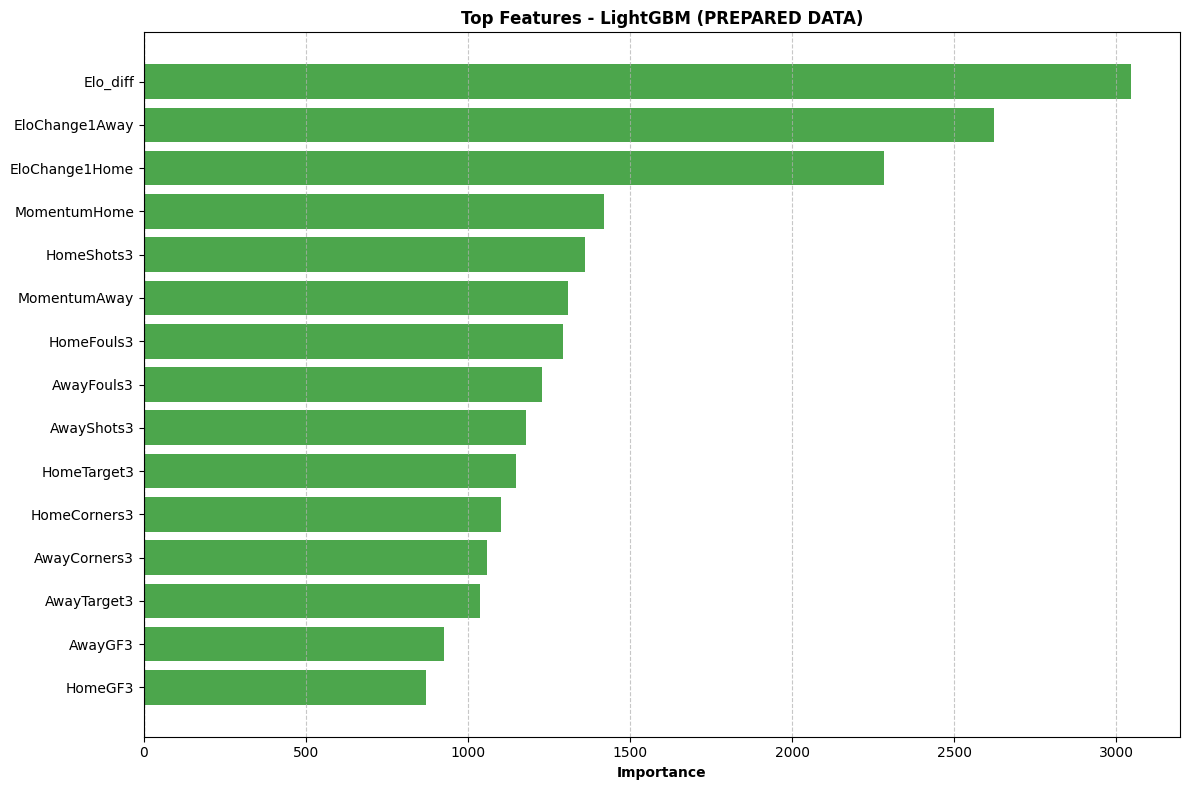


📈 Feature Insights:
   PREPARED data: Rich set of engineered features (momentum, rolling stats, rest days, etc.)


In [99]:
# Compare top features
fig, axes = plt.subplots(1, 1, figsize=(12, 8))

# Extract top 15 features from the prepared data
top_prep = results_set2['coefs'].head(15)

# Check if the model is Logistic Regression or LightGBM
if 'Coefficient' in results_set2['coefs'].columns:
    # Logistic Regression: Use Coefficients
    colors_prep = ['green' if x > 0 else 'red' for x in top_prep['Coefficient']]
    axes.barh(top_prep['Feature'], top_prep['Coefficient'], color=colors_prep, alpha=0.7)
    axes.set_xlabel('Coefficient', fontweight='bold')
    axes.set_title('Top Features - Logistic Regression (PREPARED DATA)', fontweight='bold', fontsize=12)
else:
    # LightGBM: Use Feature Importance
    colors_prep = ['green' if x > 0 else 'red' for x in top_prep['Importance']]
    axes.barh(top_prep['Feature'], top_prep['Importance'], color=colors_prep, alpha=0.7)
    axes.set_xlabel('Importance', fontweight='bold')
    axes.set_title('Top Features - LightGBM (PREPARED DATA)', fontweight='bold', fontsize=12)

# Add gridlines and invert y-axis for better readability
axes.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes.invert_yaxis()
axes.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\n📈 Feature Insights:")
print("   PREPARED data: Rich set of engineered features (momentum, rolling stats, rest days, etc.)")

## **5.3 SHAP Analysis**

🔍 SHAP Analysis for MODEL 2 - PREPARED DATA

⏳ Computing SHAP values (this may take a minute)...
✅ SHAP values computed successfully!

📊 Plotting SHAP Summary Plot...


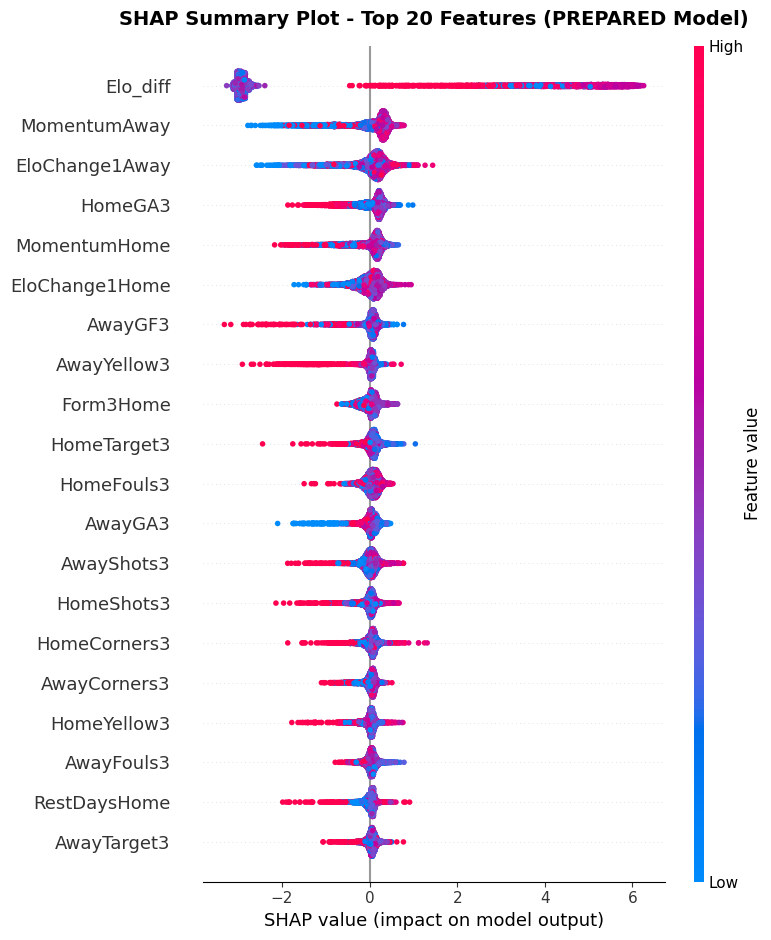


📈 Plotting SHAP Dependence Plots for Top 3 Features...
   Top 3 features: ['Elo_diff', 'MomentumAway', 'EloChange1Away']


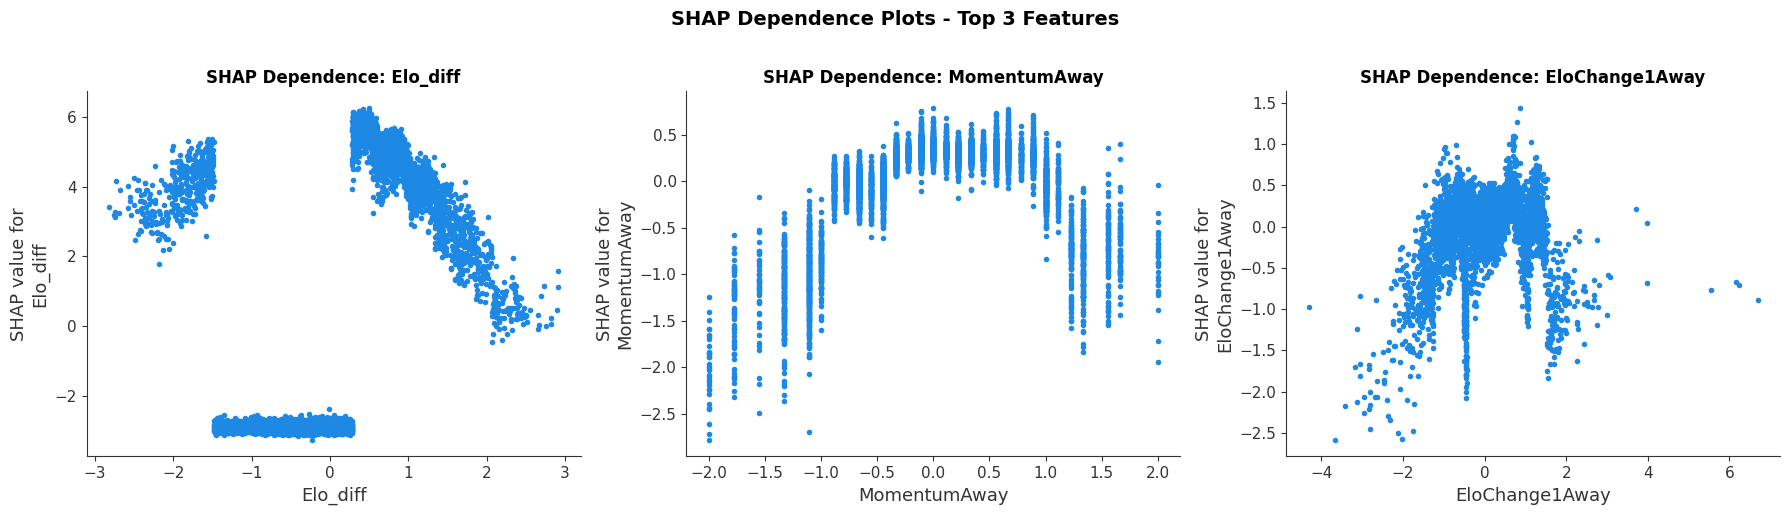


✅ SHAP analysis completed!


In [100]:
print("🔍 SHAP Analysis for MODEL 2 - PREPARED DATA")
print("="*60)

# Use the prepared model and processed test data
model = results_set2['model']
X_test_proc = results_set2['X_test_proc']

# Compute SHAP values (TreeExplainer for LightGBM)
print("\n⏳ Computing SHAP values (this may take a minute)...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_proc)

# For binary classification, shap_values might be a list [class_0, class_1]
# We want class 1 (Cinderella/Upset)
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

print("✅ SHAP values computed successfully!")

# ===================================================================
# 1. SHAP SUMMARY PLOT (Beeswarm)
# ===================================================================
print("\n📊 Plotting SHAP Summary Plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_class1, 
    X_test_proc, 
    plot_type="dot",
    show=False,
    max_display=20
)
plt.title("SHAP Summary Plot - Top 20 Features (PREPARED Model)", fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# ===================================================================
# 2. SHAP DEPENDENCE PLOTS (Top 3 features)
# ===================================================================
print("\n📈 Plotting SHAP Dependence Plots for Top 3 Features...")

# Get feature importance from absolute mean SHAP
feature_importance = np.abs(shap_values_class1).mean(axis=0)
top_features_idx = np.argsort(feature_importance)[-3:][::-1]
top_features = [X_test_proc.columns[i] for i in top_features_idx]

print(f"   Top 3 features: {top_features}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (feat_idx, feat_name) in enumerate(zip(top_features_idx, top_features)):
    ax = axes[idx]
    shap.dependence_plot(
        feat_idx,
        shap_values_class1,
        X_test_proc,
        interaction_index=None,
        ax=ax,
        show=False
    )
    ax.set_title(f"SHAP Dependence: {feat_name}", fontsize=12, fontweight='bold')

plt.suptitle("SHAP Dependence Plots - Top 3 Features", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✅ SHAP analysis completed!")